In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import cv2
import matplotlib.pyplot as plt
import contextlib
import os
import glob
import sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

In [2]:
# Cargar el modelo guardado
model = load_model("modelo_entrenado_2.h5", compile=False)

#función Expected Grad Cam
def expected_grad_cam(model, img_array, layer_name="top_conv"):
    # Obtén el submodelo que contiene la capa `top_conv`
    base_model = model.get_layer('model')  # Nombre del submodelo
    grad_model = Model(inputs=base_model.input, outputs=[base_model.get_layer(layer_name).output, base_model.output])

    predictions = model.predict(img_array)
    num_classes = predictions.shape[-1]
    heatmap_shape = (img_array.shape[1], img_array.shape[2])
    expected_heatmap = np.zeros(heatmap_shape)

    for pred_index in range(num_classes):
        with tf.GradientTape() as tape:
            inputs = tf.cast(img_array, tf.float32)
            tape.watch(inputs)
            conv_outputs, predictions_for_class = grad_model(inputs)
            class_channel = predictions_for_class[:, pred_index]  # Mantén la conexión al grafo

        # Calcula los gradientes
        grads = tape.gradient(class_channel, conv_outputs)
        if grads is None:
            print(f"Gradientes no calculados para la clase {pred_index}")
            continue

        # Pondera los gradientes
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        pooled_grads = tf.reshape(pooled_grads, [1, 1, -1])

        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
        heatmap = tf.maximum(heatmap, 0)  # ReLU para mantener solo valores positivos

        if tf.reduce_max(heatmap) > 0:
            heatmap /= tf.reduce_max(heatmap)

        # Redimensiona el mapa de calor al tamaño de la imagen de entrada
        heatmap_resized = cv2.resize(heatmap.numpy(), (heatmap_shape[1], heatmap_shape[0]), interpolation=cv2.INTER_CUBIC)

        # Pondera el mapa de calor por la probabilidad de la clase
        prob = float(predictions[0, pred_index])
        expected_heatmap += heatmap_resized * prob

    # Recorta los valores para mantenerlos entre 0 y 1
    expected_heatmap = np.clip(expected_heatmap, 0, 1)
    return expected_heatmap

# Aplicar Grad-CAM en cada fragmento y generar un mapa de calor
def apply_heatmap_on_image(image, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image, 1-alpha, heatmap, alpha, 0)
    return superimposed_img

In [3]:
# Función para calcular la entropía de las predicciones
def calculate_entropy(probabilities):
    return -np.sum(probabilities * np.log(probabilities + 1e-10))

def visualize_image_with_expected_gradcam(model, image_path, layer_name="top_conv"):
    # Crear una carpeta temporal para contener la imagen
    temp_dir = './temp_dir'
    os.makedirs(temp_dir + '/temp', exist_ok=True)

    # Copiar la imagen a la carpeta temporal
    imagen_copiada = os.path.join(temp_dir + '/temp', os.path.basename(image_path))
    shutil.copy(image_path, imagen_copiada)

    # Crear el generador de datos
    datagen = ImageDataGenerator()

    # Configurar el generador de prueba
    prueba_generator = datagen.flow_from_directory(
        directory=temp_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode=None,
        color_mode='rgb',
        shuffle=False)

    for img_array in prueba_generator:
        # Nombres de las clases 
        class_names = ['Hallazgo', 'Sin Hallazgo']
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class]

        # Calcular la entropía de la predicción
        entropy = calculate_entropy(predictions[0])
        
        # Visualizar Expected Grad-CAM
        heatmap = expected_grad_cam(model, img_array, layer_name)
        img = (img_array[0] * 255).astype(np.uint8)  # Desescalar para mostrar correctamente
        superimposed_img = apply_heatmap_on_image(img, heatmap)
        
        plt.imshow(superimposed_img)
        plt.title(f"Expected Grad Cam", fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca())

        # Añadir un texto con las métricas en la parte inferior de la imagen
        title_text = 'Resultados'
        metrics_text = (f'Clase predicha: {class_names[predicted_class]}\n'
                        f'Probabilidad: {confidence:.4f}\n'
                        f'Entropía: {entropy:.4f}\n')
        
        # Combinar el título y las métricas en un solo recuadro
        plt.figtext(0.5, 0.05, title_text, ha="center", va="top", fontsize=14, weight='bold', bbox={"facecolor": "lightgray", "alpha": 0})

        # Añadir las métricas, alineadas a la izquierda, justo debajo del título
        plt.figtext(0.35, 0.005, metrics_text, ha="left", va="top", fontsize=12, bbox={"facecolor": "lightgray", "alpha": 0})
        plt.axis("on") 
        plt.gca().invert_yaxis()
        plt.show()
        break  # Salir después de la primera imagen

    # Limpiar la carpeta temporal
    shutil.rmtree(temp_dir)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 20ms/step


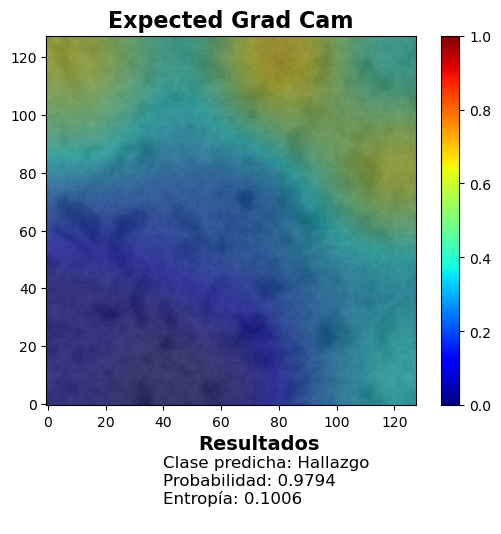

In [4]:
# Ejemplo de uso con la ruta de imagen proporcionada
image_path = r"fragmentos/0f37159abdcef6a062e404df47e8f1ac_1_BI-RADS_4_22.png"
visualize_image_with_expected_gradcam(model, image_path)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 30ms/step


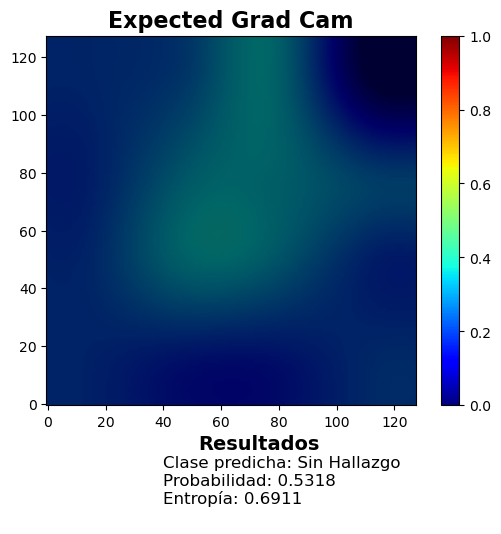

In [5]:
# Ejemplo de uso con la ruta de imagen proporcionada
image_path = r"fragmentos_1/0f37159abdcef6a062e404df47e8f1ac_1.png"
visualize_image_with_expected_gradcam(model, image_path)

In [6]:
# Función para aplicar el texto con la clase en la imagen
def add_text_to_image(image, text, position=(10, 30), font_scale=0.6, color=(255, 255, 255), thickness=1):
    font = cv2.FONT_HERSHEY_SIMPLEX
    return cv2.putText(image, text, position, font, font_scale, color, thickness, cv2.LINE_AA)

# Función para suprimir la salida de la consola
@contextlib.contextmanager
def suppress_stdout():
    original_stdout = sys.stdout  # Guardar el valor de sys.stdout
    sys.stdout = open(os.devnull, 'w')  # Redirigir sys.stdout a null
    try:
        yield
    finally:
        sys.stdout.close()  # Cerrar el archivo temporal
        sys.stdout = original_stdout  # Restaurar sys.stdout

# Función para procesar y combinar los fragmentos en una imagen final
def process_and_visualize_fragments(model, fragment_dir, fragment_size, num_rows, num_cols, layer_name="top_conv"):
    final_image = np.zeros((fragment_size[0] * num_rows, fragment_size[1] * num_cols, 3), dtype=np.uint8)

    for i, num in enumerate(range(1, num_rows * num_cols + 1)):
        fragment_paths = glob.glob(os.path.join(fragment_dir, f'*_{num}.png'))
        if not fragment_paths:
            continue
        fragment_path = fragment_paths[0]

        # Crear una carpeta temporal para contener la imagen
        temp_dir = './temp_dir'
        os.makedirs(temp_dir + '/temp', exist_ok=True)

        # Copiar la imagen a la carpeta temporal
        imagen_copiada = os.path.join(temp_dir + '/temp', os.path.basename(fragment_path))
        shutil.copy(fragment_path, imagen_copiada)

        # Crear el generador de datos
        datagen = ImageDataGenerator()

        with suppress_stdout():
            prueba_generator = datagen.flow_from_directory(
                directory=temp_dir,
                target_size=fragment_size,
                batch_size=32,
                class_mode=None,
                color_mode='rgb',
                shuffle=False
            )

        for img_array in prueba_generator:
            predictions = model.predict(img_array, verbose=0)
            prediction_percentages = (predictions[0] * 100).round(0)  # Convertir a porcentaje y redondear

            # Formatear el texto de las dos clases y porcentajes 
            class_text = f'[{prediction_percentages[0]:.0f}%, {prediction_percentages[1]:.0f}%]'
            # Generar el mapa de calor con Grad-CAM e invertirlo
            with suppress_stdout():
                heatmap =  expected_grad_cam(model, img_array, layer_name=layer_name)
            heatmap = 1 - heatmap
            img = (img_array[0] * 255).astype(np.uint8)  # Desescalar para mostrar correctamente

            # Superponer el mapa de calor sobre la imagen original
            superimposed_img = apply_heatmap_on_image(img, heatmap)

            # Añadir el texto de todas las clases con sus porcentajes en la esquina inferior del fragmento
            text_position = (10, 30)  # Ajustar la posición para que esté cerca de la esquina inferior izquierda
            superimposed_img = add_text_to_image(superimposed_img, class_text)

            # Calcular la posición en la imagen final
            row = i // num_cols
            col = i % num_cols
            final_image[row * fragment_size[0]:(row + 1) * fragment_size[0],
                        col * fragment_size[1]:(col + 1) * fragment_size[1]] = superimposed_img
            break  # Procesar solo la primera imagen en el generador

        # Limpiar la carpeta temporal
        shutil.rmtree(temp_dir)

    return final_image

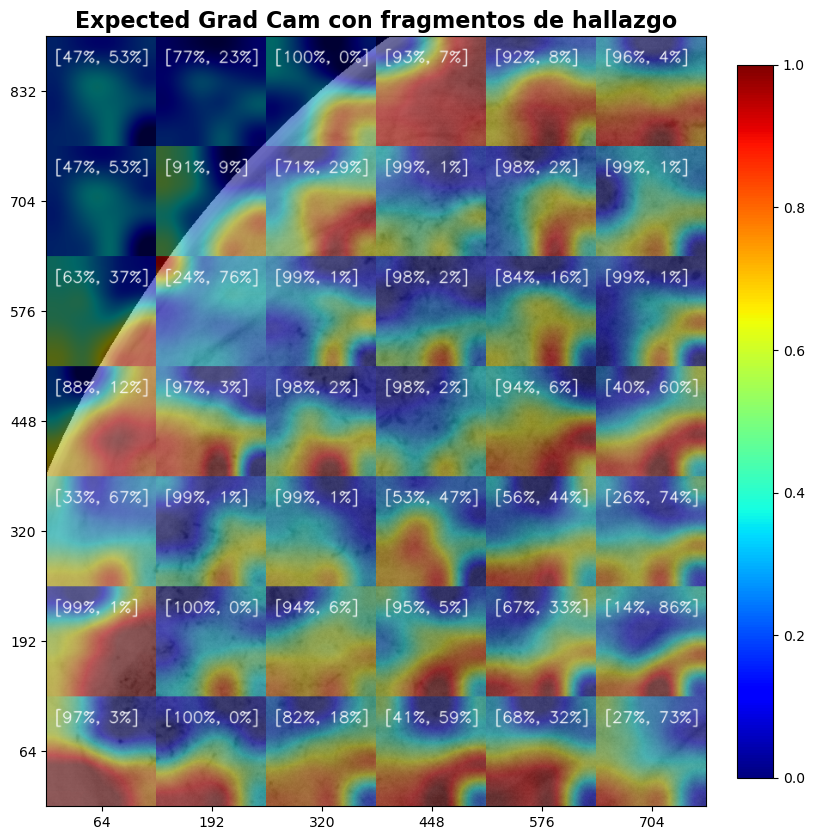

In [7]:
# Ejemplo de uso de la función
fragment_dir = 'fragmentos'  # Define tu directorio de fragmentos
fragment_size = (128, 128)  # Define el tamaño de cada fragmento
num_rows = 7  # Define el número de filas en la imagen final
num_cols = 6  # Define el número de columnas en la imagen final

# Procesar los fragmentos
final_image = process_and_visualize_fragments(model, fragment_dir, fragment_size, num_rows, num_cols)

# Invertir la imagen final verticalmente antes de mostrarla
final_image_inverted = cv2.flip(final_image, 0)

# Mostrar la imagen final con todos los fragmentos y sus mapas de calor
plt.figure(figsize=(10, 10))  # Ajusta el tamaño de la figura según lo que necesites
plt.imshow(cv2.cvtColor(final_image_inverted, cv2.COLOR_BGR2RGB), origin='lower')  # Usa la imagen original, sin inversión

# Modificar las unidades del eje x y y
x_ticks = np.arange(64, final_image.shape[1], 128)
y_ticks = np.arange(64, final_image.shape[0], 128)

# Asegurarse de que la última marca sea 64 si está en el rango
if final_image.shape[1] >= 64 and 64 not in x_ticks:
    x_ticks = np.append(64, x_ticks)
if final_image.shape[0] >= 64 and 64 not in y_ticks:
    y_ticks = np.append(64, y_ticks)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title(f"Expected Grad Cam con fragmentos de hallazgo", fontsize=16, fontweight='bold')
plt.axis('on')  # Mostrar los ejes con marcas
plt.gca().set_ylim([0, final_image.shape[0]])  # Configuración normal para que el origen esté en la esquina superior izquierda
plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca(), fraction=0.046, pad=0.04)  # Añadir barra de colores
plt.show()

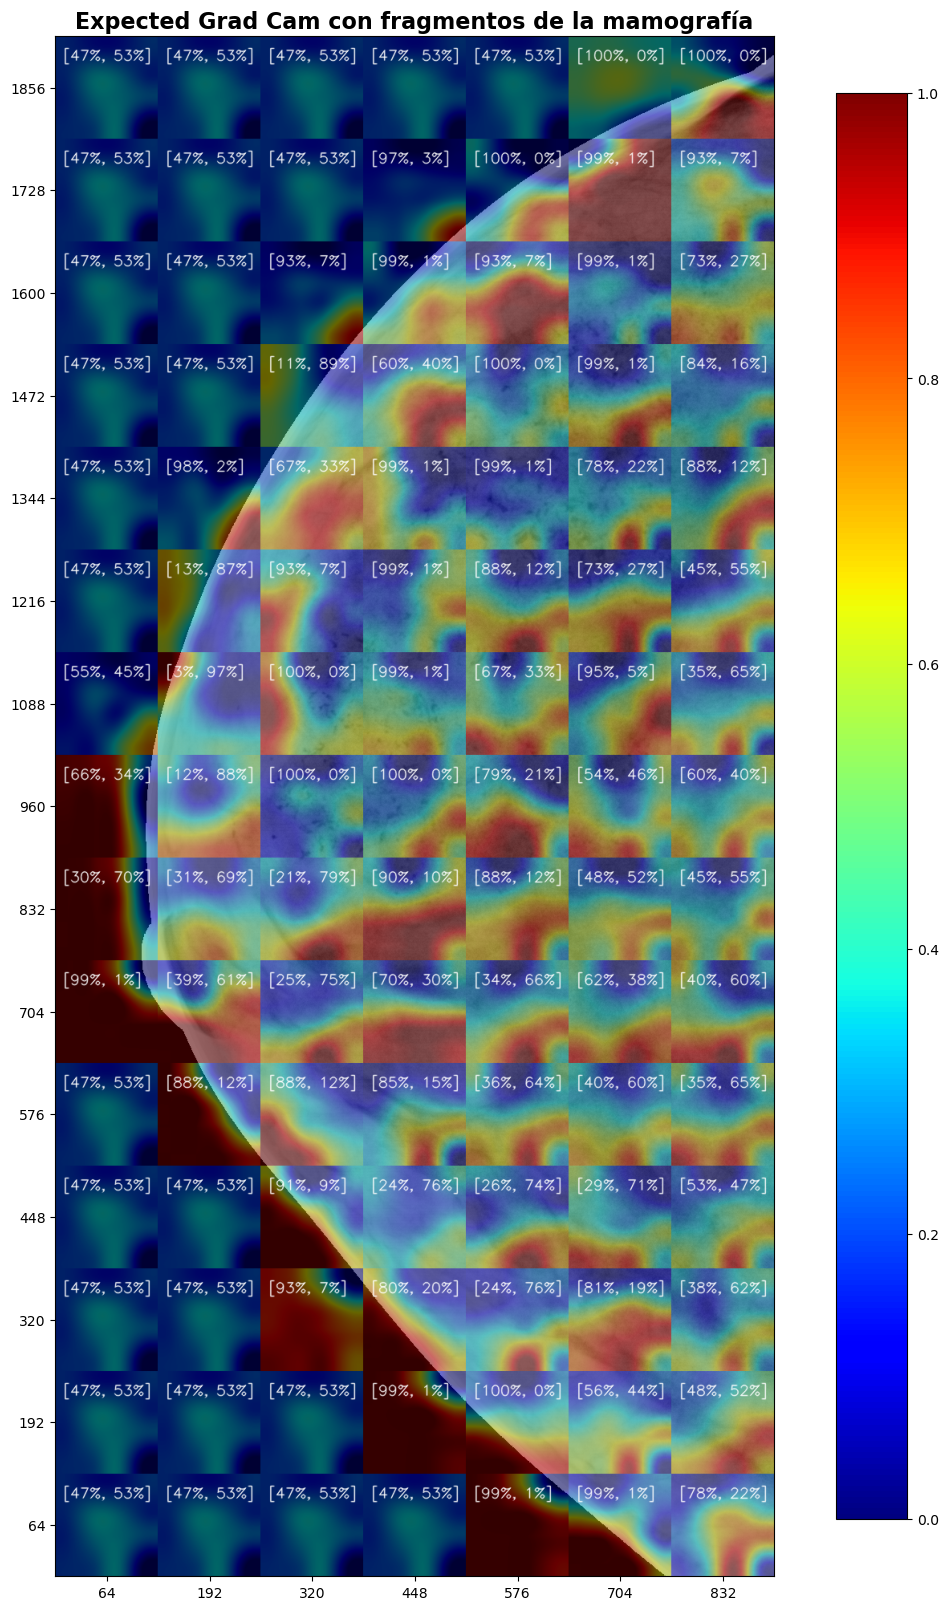

In [8]:
# Directorio donde se encuentran los fragmentos
fragment_dir = 'fragmentos_1'
fragment_size = (128, 128)  # Tamaño de los fragmentos
num_rows = 15  # Número de filas en la imagen final
num_cols = 7  # Número de columnas en la imagen final

# Procesar los fragmentos
final_image = process_and_visualize_fragments(model, fragment_dir, fragment_size, num_rows, num_cols)
# Invertir la imagen final verticalmente antes de mostrarla
final_image_inverted = cv2.flip(final_image, 0)

# Mostrar la imagen final con todos los fragmentos y sus mapas de calor
plt.figure(figsize=(20, 20))  # Ajusta el tamaño de la figura según lo que necesites
plt.imshow(cv2.cvtColor(final_image_inverted, cv2.COLOR_BGR2RGB), origin='lower')
x_ticks = np.arange(64, final_image.shape[1], 128)
y_ticks = np.arange(64, final_image.shape[0], 128)
if final_image.shape[1] >= 64 and 64 not in x_ticks:
    x_ticks = np.append(64, x_ticks)
if final_image.shape[0] >= 64 and 64 not in y_ticks:
    y_ticks = np.append(64, y_ticks)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title(f"Expected Grad Cam con fragmentos de la mamografía", fontsize=16, fontweight='bold')
plt.axis('on')  # Mostrar los ejes con marcas
plt.gca().set_ylim([0, final_image.shape[0]])  # Configuración normal para que el origen esté en la esquina superior izquierda
plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca(), fraction=0.046, pad=0.04)  # Añadir barra de colores
plt.show()

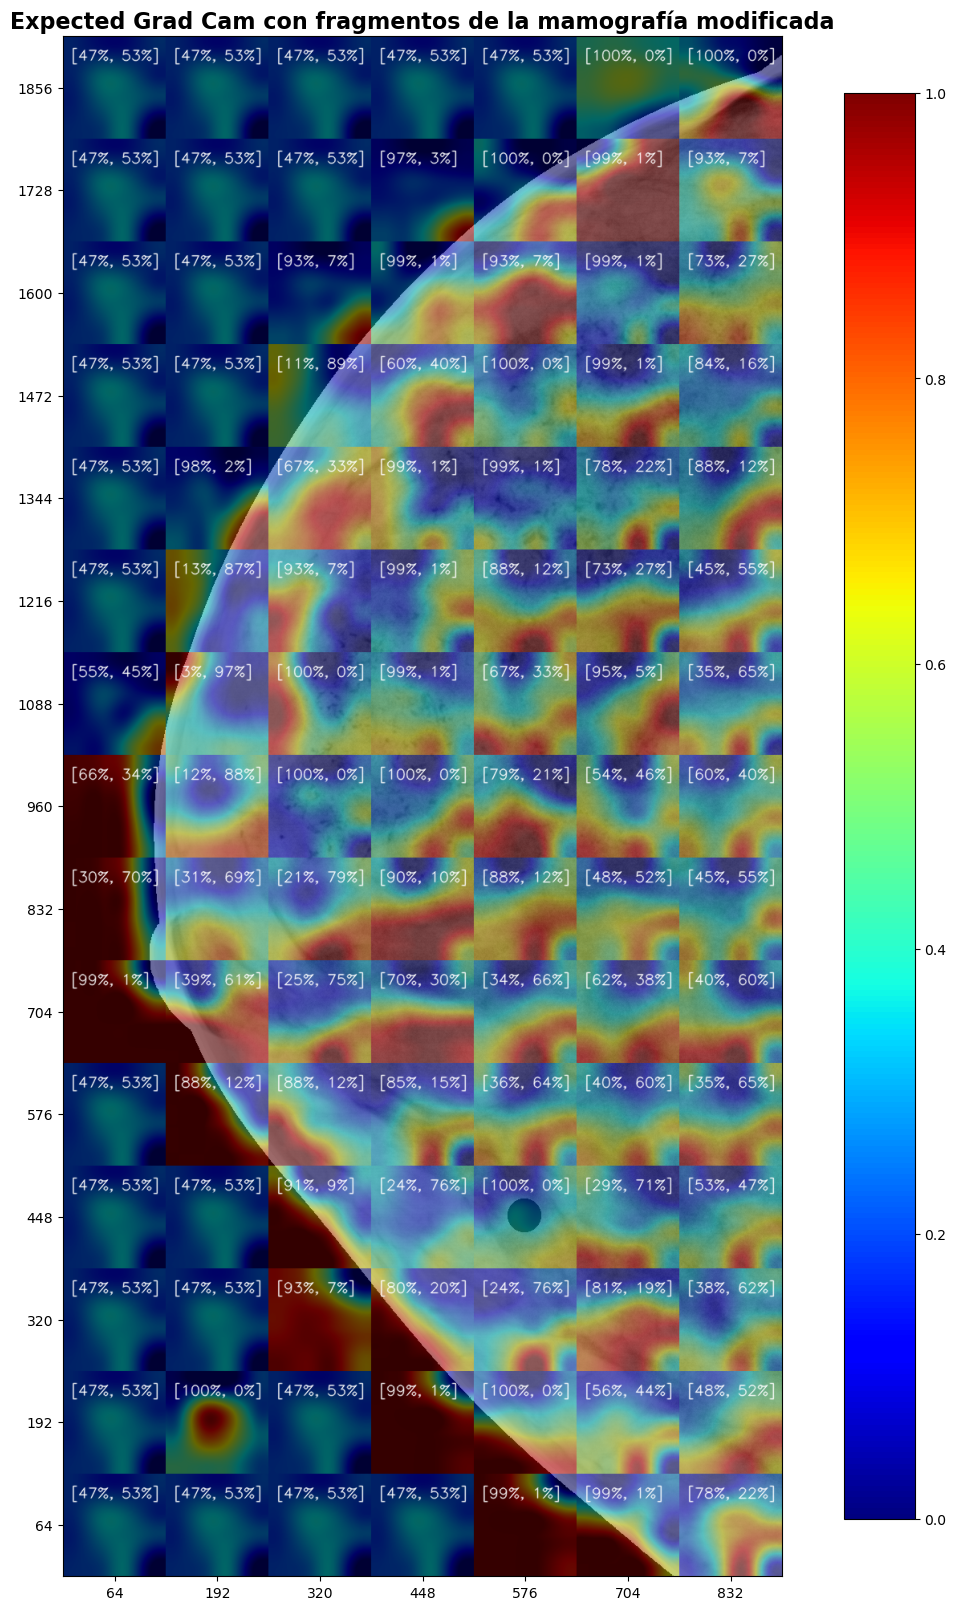

In [9]:
# Directorio donde se encuentran los fragmentos
fragment_dir = 'fragmentos_2'
fragment_size = (128, 128)  # Tamaño de los fragmentos
num_rows = 15  # Número de filas en la imagen final
num_cols = 7  # Número de columnas en la imagen final

# Procesar los fragmentos
final_image = process_and_visualize_fragments(model, fragment_dir, fragment_size, num_rows, num_cols)
# Invertir la imagen final verticalmente antes de mostrarla
final_image_inverted = cv2.flip(final_image, 0)

# Mostrar la imagen final con todos los fragmentos y sus mapas de calor
plt.figure(figsize=(20, 20))  # Ajusta el tamaño de la figura según lo que necesites
plt.imshow(cv2.cvtColor(final_image_inverted, cv2.COLOR_BGR2RGB), origin='lower')  # Usa la imagen original, sin inversión
x_ticks = np.arange(64, final_image.shape[1], 128)
y_ticks = np.arange(64, final_image.shape[0], 128)
if final_image.shape[1] >= 64 and 64 not in x_ticks:
    x_ticks = np.append(64, x_ticks)
if final_image.shape[0] >= 64 and 64 not in y_ticks:
    y_ticks = np.append(64, y_ticks)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title(f"Expected Grad Cam con fragmentos de la mamografía modificada", fontsize=16, fontweight='bold')
plt.axis('on')  # Mostrar los ejes con marcas
plt.gca().set_ylim([0, final_image.shape[0]])  # Configuración normal para que el origen esté en la esquina superior izquierda
plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca(), fraction=0.046, pad=0.04)  # Añadir barra de colores
plt.show()

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 17ms/step


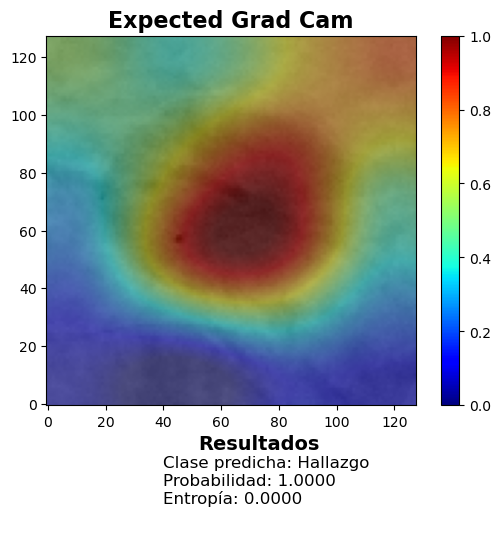

In [10]:
# Ejemplo de uso con la ruta de imagen proporcionada
image_path = r"dbfffde4219dfb6aab1a5fe2d21a99d0_1_BI-RADS_4.png"
visualize_image_with_expected_gradcam(model, image_path)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 25ms/step


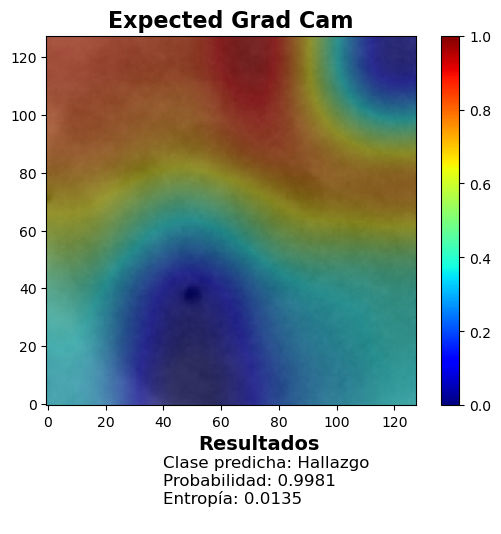

In [11]:
# Ejemplo de uso con la ruta de imagen proporcionada
image_path = r"fragmentos_4/dbfffde4219dfb6aab1a5fe2d21a99d0_92.png"
visualize_image_with_expected_gradcam(model, image_path)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 19ms/step


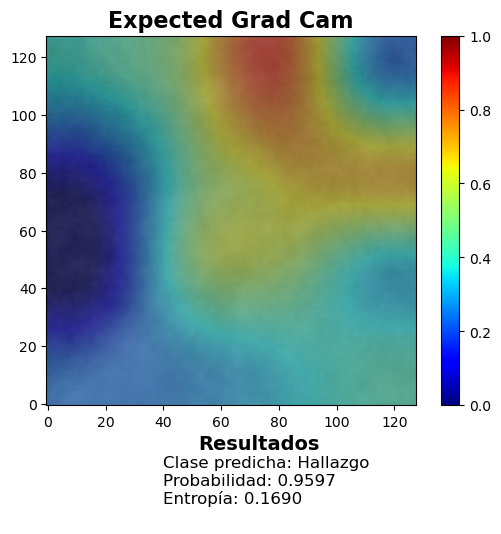

In [12]:
# Ejemplo de uso con la ruta de imagen proporcionada
image_path = r"fragmentos_4/dbfffde4219dfb6aab1a5fe2d21a99d0_93.png"
visualize_image_with_expected_gradcam(model, image_path)

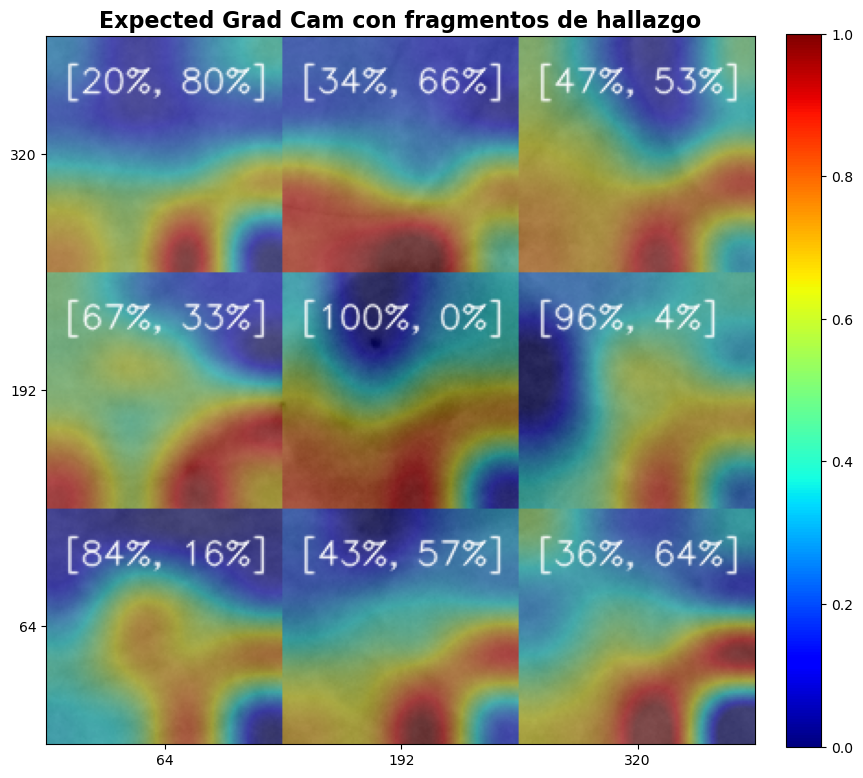

In [13]:
# Ejemplo de uso de la función
fragment_dir = 'fragmentos_3'  # Define tu directorio de fragmentos
fragment_size = (128, 128)  # Define el tamaño de cada fragmento
num_rows = 3  # Define el número de filas en la imagen final
num_cols = 3  # Define el número de columnas en la imagen final

# Procesar los fragmentos
final_image = process_and_visualize_fragments(model, fragment_dir, fragment_size, num_rows, num_cols)
# Invertir la imagen final verticalmente antes de mostrarla
final_image_inverted = cv2.flip(final_image, 0)

# Mostrar la imagen final con todos los fragmentos y sus mapas de calor
plt.figure(figsize=(10, 10))  # Ajusta el tamaño de la figura según lo que necesites
plt.imshow(cv2.cvtColor(final_image_inverted, cv2.COLOR_BGR2RGB), origin='lower')  # Usa la imagen original, sin inversión
# Modificar las unidades del eje x y y
x_ticks = np.arange(64, final_image.shape[1], 128)
y_ticks = np.arange(64, final_image.shape[0], 128)
if final_image.shape[1] >= 64 and 64 not in x_ticks:
    x_ticks = np.append(64, x_ticks)
if final_image.shape[0] >= 64 and 64 not in y_ticks:
    y_ticks = np.append(64, y_ticks)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title(f"Expected Grad Cam con fragmentos de hallazgo", fontsize=16, fontweight='bold')
plt.axis('on')  # Mostrar los ejes con marcas
plt.gca().set_ylim([0, final_image.shape[0]])  # Configuración normal para que el origen esté en la esquina superior izquierda
plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca(), fraction=0.046, pad=0.04)  # Añadir barra de colores
plt.show()

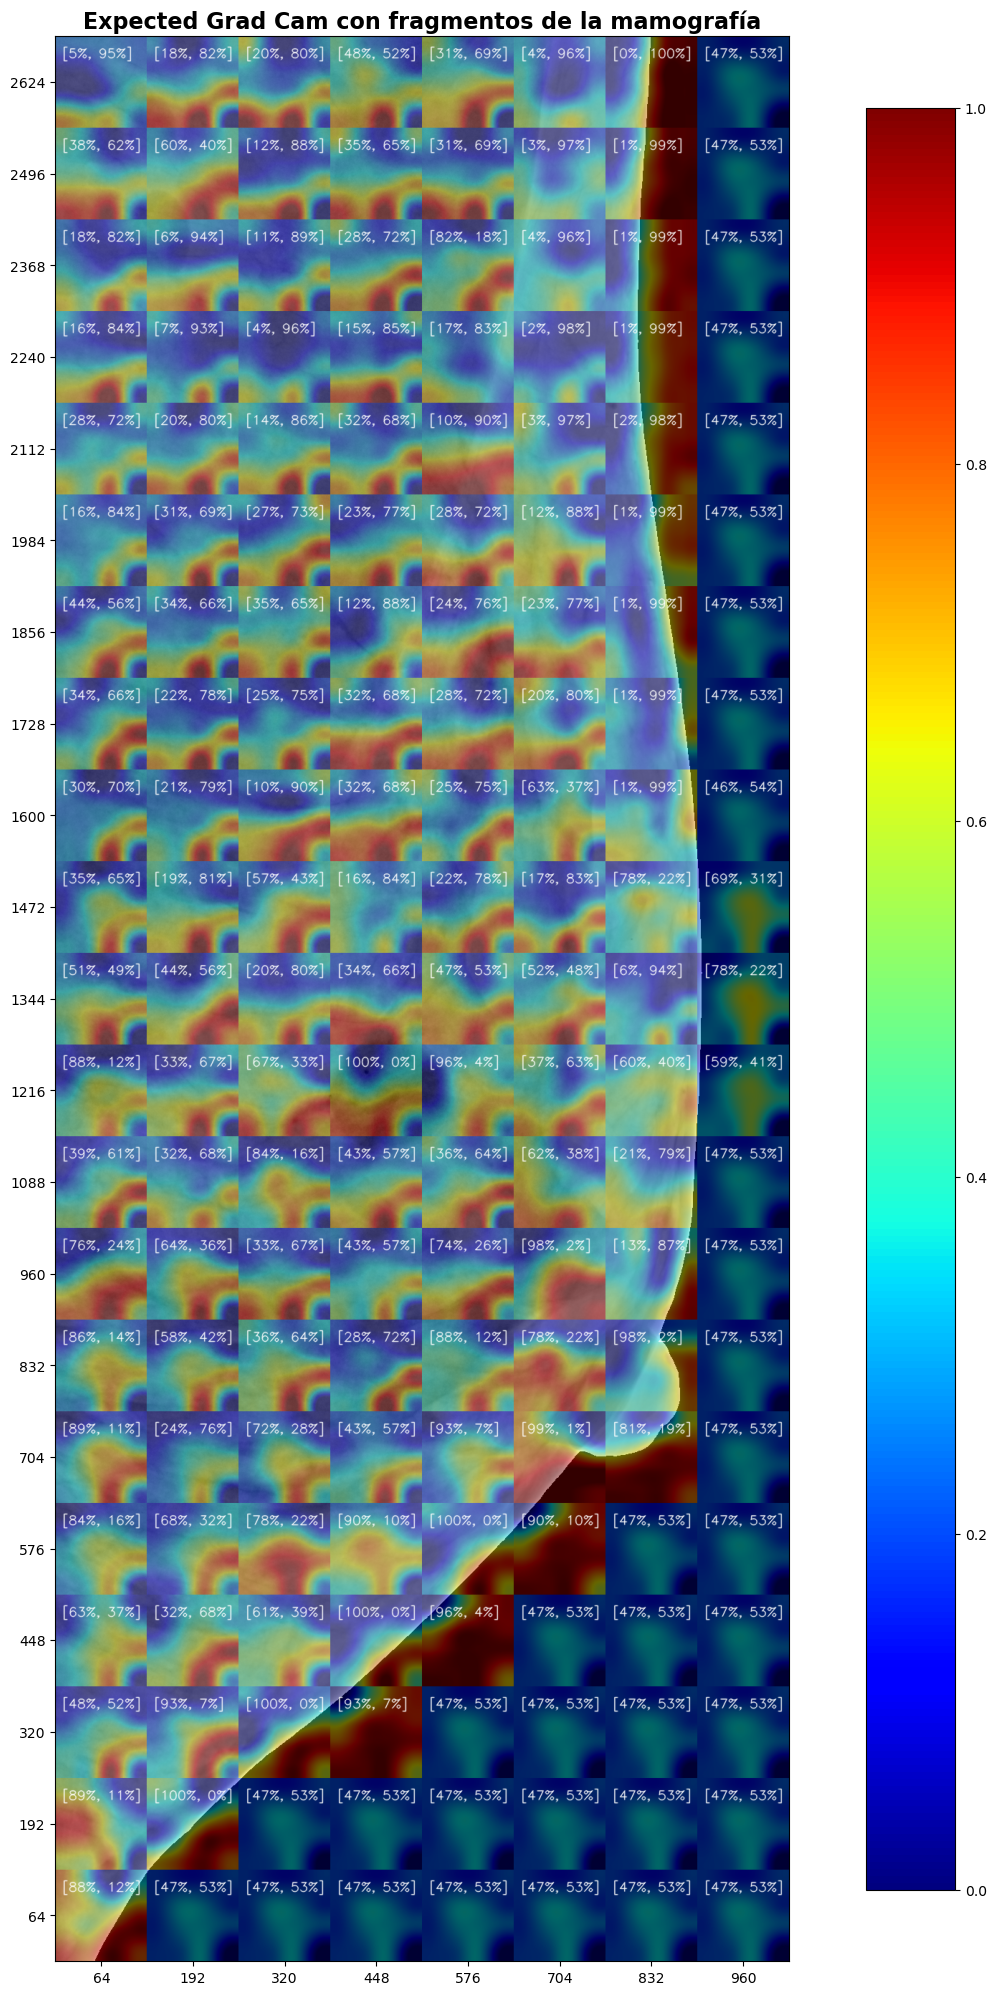

In [14]:
# Directorio donde se encuentran los fragmentos
fragment_dir = 'fragmentos_4'
fragment_size = (128, 128)  # Tamaño de los fragmentos
num_rows = 21  # Número de filas en la imagen final
num_cols = 8  # Número de columnas en la imagen final

# Procesar los fragmentos
final_image = process_and_visualize_fragments(model, fragment_dir, fragment_size, num_rows, num_cols)
# Invertir la imagen final verticalmente antes de mostrarla
final_image_inverted = cv2.flip(final_image, 0)

# Mostrar la imagen final con todos los fragmentos y sus mapas de calor
plt.figure(figsize=(25, 25))  # Ajusta el tamaño de la figura según lo que necesites
plt.imshow(cv2.cvtColor(final_image_inverted, cv2.COLOR_BGR2RGB), origin='lower')  # Usa la imagen original, sin inversión
x_ticks = np.arange(64, final_image.shape[1], 128)
y_ticks = np.arange(64, final_image.shape[0], 128)
if final_image.shape[1] >= 64 and 64 not in x_ticks:
    x_ticks = np.append(64, x_ticks)
if final_image.shape[0] >= 64 and 64 not in y_ticks:
    y_ticks = np.append(64, y_ticks)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.title(f"Expected Grad Cam con fragmentos de la mamografía", fontsize=16, fontweight='bold')
plt.axis('on')  # Mostrar los ejes con marcas
plt.gca().set_ylim([0, final_image.shape[0]])  # Configuración normal para que el origen esté en la esquina superior izquierda
plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=plt.gca(), fraction=0.046, pad=0.04)  # Añadir barra de colores
plt.show()